In [5]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import requests
import math
import urllib
import seaborn as sns
import json
from sklearn.feature_extraction import _stop_words
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
nltk.download('omw-1.4')
import shutil
from mpl_toolkits.basemap import Basemap
import zipfile
from zipfile import ZipFile
import os
import re
#from fa2 import ForceAtlas2
import random
import community

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data importing, cleaning and preparing

In [2]:
url = 'https://raw.githubusercontent.com/d2ski/football-transfers-data/main/dataset/transfers.csv'
df = pd.read_csv(url)

In [4]:
print('We have in total %s European clubs which are buying or selling a total of %s players to %s differents clubs from all over the world'%(len(df['team_name'].unique()),len(df),len(df['counter_team_name'].unique())))

We have in total 243 European clubs which are buying or selling a total of 70006 players to 3610 differents clubs from all over the world


Getting cities/coordinates of clubs headquarters

In [5]:
df_geo=pd.read_csv('wikidata_query.csv')
#df_geo=df_geo[['clubLabel', 'Latitude', 'Longitude', 'Transfermarkt_team_ID', 'headquarters_locationLabel']]

In [6]:
df_geo['club'].replace('entity','wiki',inplace=True, regex=True)
df_geo.head()

club               clubLabel  \
0  http://www.wikidata.org/wiki/Q18528             Woking F.C.   
1  http://www.wikidata.org/wiki/Q18529          Wrexham A.F.C.   
2  http://www.wikidata.org/wiki/Q18656  Manchester United F.C.   
3  http://www.wikidata.org/wiki/Q18659     Swansea City A.F.C.   
4  http://www.wikidata.org/wiki/Q18660         Altrincham F.C.   

                                     venue         venueLabel  \
0  http://www.wikidata.org/entity/Q6412727  Kingfield Stadium   
1  http://www.wikidata.org/entity/Q1202579  Racecourse Ground   
2    http://www.wikidata.org/entity/Q83457       Old Trafford   
3   http://www.wikidata.org/entity/Q580480    Liberty Stadium   
4  http://www.wikidata.org/entity/Q2440403          Moss Lane   

                        coordinates  Longitude   Latitude  \
0        Point(-0.558811 51.306333)  -0.558811  51.306333   
1        Point(-3.003611 53.051944)  -3.003611  53.051944   
2  Point(-2.291388888 53.463055555)  -2.291389  53.463056   
3            Point(-3.9351 51.6422)  -3.935100  51.642200   
4        Point(-2.335158 53.383436)  -2.335158  53.383436   

   Transfermarkt_team_ID                   headquarters_location  \
0                    NaN  http://www.wikidata.org/entity/Q646225   
1                 1112.0  http://www.wikidata.org/entity/Q496368   
2                  985.0   http://www.wikidata.org/entity/Q18125   
3                 2288.0   http://www.wikidata.org/entity/Q23051   
4                    NaN  http://www.wikidata.org/entity/Q445058   

  headquarters_locationLabel  
0                     Woking  
1                    Wrexham  
2                 Manchester  
3                    Swansea  
4                 Altrincham

Now we'll the wikipedia page content for each club, first we extract the link and then the content

In [7]:
def get_link(link):
    test_str = requests.get(link).text

    # initializing tag
    tag = 'span class="wikibase-sitelinkview-page" dir="auto" lang="en"'

    # regex to extract required strings
    reg_str = "<" + tag + ">(.*?)</" + 'span' + ">"
    res = re.findall(reg_str, str(test_str))

    reg_str = 'href="https://en.wikipedia.org/wiki/'+ "(.*?)" '"'
    res = re.findall(reg_str, str(res))
    if len(res)>0:
        return(res[0])

In [ ]:
df_geo['link']=df_geo['club'].apply(get_link)

In [ ]:
def addpage(character):
    try:
        baseurl = "https://en.wikipedia.org/w/api.php?"
        action = "action=query"
        title = 'titles={}'.format(character)
        content = "prop=revisions&rvprop=content"
        dataformat ="format=json"
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        try:
            wikiresponse = urllib.request.urlopen(query)
        except UnicodeEncodeError:
            return (UnicodeEncodeError)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')
        try:
            imports = json.loads(wikitext)
        except json.JSONDecodeError:
            return("Empty response")
        try:           
            for key in imports['query']['pages'].keys():
                response=imports['query']['pages'][key]['revisions'][0]['*']
        except KeyError:
            return(KeyError)
        return response 
    except BaseException as error:
        return (error)

In [ ]:
df_geo['WikiContent']=df_geo['link'].apply(addpage)

Now we'll process the text

In [35]:
def text_processing(text,lemmatizing=True,stop=True):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    if stop:
        text = " ".join([w for w in text.split() 
                         if w not in Stop_Words])
    if lemmatizing:
        # stemming / lematizing (optional)
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [ ]:
df_geo['WikiContent']=df_geo['WikiContent'].apply(text_processing)

We will run the sentiment analysis for each wiki page

In [ ]:
import nltk  #https://github.com/cjhutto/vaderSentiment
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
def sentiment(text):
    sia = SentimentIntensityAnalyzer()
    return(sia.polarity_scores(text))

In [ ]:
df_geo['sentiment']=df_geo['WikiContent'].apply(sentiment)

In [ ]:
df_geo2 = pd.concat([df_geo, pd.DataFrame(list(df_geo.sentiment))], axis=1)

In [ ]:
sns.distplot(df_geo2['compound']) #Histogram on sentiment values

In [ ]:
df_geo2.to_csv('Clubs_Sentiment_WikiContent.csv')

Now we'll do the same but for every player

In [ ]:
import warnings
warnings.filterwarnings("ignore")
df_players=pd.read_csv('football_players_link.csv',dtype={'association_football_player': 'str', 'Transfermarkt_player_ID': 'str'})
def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True
df_player=df_players[df_players['Transfermarkt_player_ID'].apply(lambda x: is_float(x))]
df_player.dropna(subset=['Transfermarkt_player_ID'],inplace=True)
df_player['Transfermarkt_player_ID']=df_player['Transfermarkt_player_ID'].astype(int)

In [ ]:
url = 'https://raw.githubusercontent.com/d2ski/football-transfers-data/main/dataset/transfers.csv'
df = pd.read_csv(url)
df['player_id']=df['player_id'].astype(int)

In [ ]:
df=df.merge(df_player,left_on='player_id',right_on='Transfermarkt_player_ID',how='left')
df.drop('Transfermarkt_player_ID',axis=1)
print('We have %s players with no link'%df.drop_duplicates(subset='player_id')['association_football_player'].isna().sum())

In [ ]:
df2=df.drop_duplicates(subset='player_id')
df2=df2.dropna(subset='association_football_player')
df2['association_football_player'].replace('entity','wiki',inplace=True, regex=True)
del df2['Transfermarkt_player_ID']

In [ ]:
df2['link']=df2['association_football_player'].apply(get_link)
df2['WikiContent']=df2['link'].apply(addpage)
df2['sentiment']=df2['WikiContent'].apply(sentiment)

In [ ]:
df3=df2.join(df2['sentiment'].apply(pd.Series))
df3=df3[['player_id','WikiContent','sentiment', 'neg','neu', 'pos', 'compound']]
df=df.merge(df3,on='player_id',how='left')

In [ ]:
df3

In [ ]:
sns.distplot(df3['compound']) #Histogram on sentiment values

In [ ]:
df=pd.read_csv('Transfers_Sentiment_WikiContent.csv',index_col=0)

Preparing for merging the club dataframe with the transfer dataframe

In [ ]:
df_geo=pd.read_csv('Clubs_Sentiment_WikiContent.csv',index_col=0)

In [ ]:
df_geo.rename(columns={'sentiment': 'sentiment_club', 'neg': 'neg_club', 'neu': 'neu_club', 'pos': 'pos_club', 'compound': 'compound_club','WikiContent':'WikiContent_club'}, inplace=True)
df.rename(columns={'sentiment': 'sentiment_player', 'neg': 'neg_player', 'neu': 'neu_player', 'pos': 'pos_player', 'compound': 'compound_player','WikiContent':'WikiContent_player'}, inplace=True)
df_geo=df_geo[['Longitude','Latitude', 'Transfermarkt_team_ID','WikiContent_club', 'sentiment_club','neg_club', 'neu_club', 'pos_club', 'compound_club','headquarters_locationLabel']]

In [ ]:
df=df[df.counter_team_id!='Retired'] # I was getting an error when transforming to integer
df_geo['Transfermarkt_team_ID']=df_geo['Transfermarkt_team_ID'].astype(int,errors='ignore')
df['team_id']=df['team_id'].astype(int)
df['counter_team_id']=df['counter_team_id'].astype(int)

Merging geographical data for clubs

In [ ]:
df=df.merge(df_geo,left_on='team_id',right_on='Transfermarkt_team_ID',how='left')
df=df.merge(df_geo,left_on='counter_team_id',right_on='Transfermarkt_team_ID',how='left',suffixes=('_team', '_counter_team'))
df.drop(['Transfermarkt_team_ID_team','Transfermarkt_team_ID_counter_team'],axis=1,inplace=True)

In [ ]:
print('We have %s rows with no info on the English team coordinates'%len(df[df['Latitude_team'].isna()]))
print('We have %s rows with no info on the other team coordinates'%len(df[df['Latitude_counter_team'].isna()]))

For those clubs that have no info on the location, we are going to assign the average latitude and longitude of the country they belong

In [ ]:
url = 'https://gist.githubusercontent.com/metal3d/5b925077e66194551df949de64e910f6/raw/c5f20a037409d96958553e2eb6b8251265c6fd63/country-coord.csv'
df_location_countries = pd.read_csv(url)
df_location_countries['Latitude (average)']=df_location_countries['Latitude (average)'].astype(int)
df_location_countries['Longitude (average)']=df_location_countries['Longitude (average)'].astype(int)

In [ ]:
df=df.merge(df_location_countries,left_on='team_country',right_on='Country',how='left')
df=df.merge(df_location_countries,left_on='counter_team_country',right_on='Country',how='left',suffixes=('_team', '_counter_team'))
for index,row in df[df['Latitude_counter_team'].isna()].iterrows():
    df.loc[index,'Latitude_counter_team']=df.loc[index,'Latitude (average)_counter_team']
    df.loc[index,'Longitude_counter_team']=df.loc[index,'Longitude (average)_counter_team']
for index,row in df[df['Latitude_team'].isna()].iterrows():
    df.loc[index,'Latitude_team']=df.loc[index,'Latitude (average)_team']
    df.loc[index,'Longitude_team']=df.loc[index,'Longitude (average)_team']

In [ ]:
print('Now, we have %s rows with no info on the other team coordinates'%len(df[df['Latitude_counter_team'].isna()]))
print('But, for example, we have %s rows that are minor division of the clubs, such as "Chelsea U18"'%len(df[df['counter_team_name'].str.match(r'(.* U[0-9][0-9]$)')==True]['counter_team_name']))
print('Also, we have %s rows that are Reserves division of the clubs, such as "Chelsea Reserves"'%len(df[df['counter_team_name'].str.match(r'(.* Reserves$)')==True]['counter_team_name']))

Now, we'll replace the latitude and longitude of the minor division with the major club

In [ ]:
for index,row in df.loc[(df['team_name'].str.match(r'(.* U[0-9][0-9]$)')==True)|(df['team_name'].str.match(r'(.* Reserves$)')==True)].iterrows():
    if pd.isna(row['Longitude_team']):
        for index2,row2 in df.drop_duplicates(subset='team_name').iterrows():
            if row2['team_name']==row['team_name'][:-4]:
                df.loc[index,'Latitude_team']=df.loc[index2,'Latitude_team']
                df.loc[index,'Longitude_team']=df.loc[index2,'Longitude_team']

In [ ]:
for index,row in df.loc[(df['counter_team_name'].str.match(r'(.* U[0-9][0-9]$)')==True)|(df['counter_team_name'].str.match(r'(.* Reserves$)')==True)].iterrows():
    if pd.isna(row['Longitude_counter_team']):
        for index2,row2 in df.drop_duplicates(subset='counter_team_name').iterrows():
            if row2['counter_team_name']==row['counter_team_name'][:-4]:
                df.loc[index,'Latitude_counter_team']=df.loc[index2,'Latitude_counter_team']
                df.loc[index,'Longitude_counter_team']=df.loc[index2,'Longitude_counter_team']

In [ ]:
print('We have %s rows with no info on the Enropean team coordinates'%len(df[df['Latitude_team'].isna()]))
print('Now, we have %s rows with no info on the other team coordinates. \nAs we can see below, most of them are small English clubs or player coming from no particular club.\nWe have to bear in mind there are 40,000 association football clubs in England, more than any other country'%len(df[df['Latitude_counter_team'].isna()]))
print(df[df['Latitude_counter_team'].isna()].groupby('counter_team_country').count()['team_id'])

Continent merging

In [ ]:
url='https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-continent.json'
df_continents = pd.read_json(url)
#df_continents.loc[63,'continent']='England'
new_rows = pd.DataFrame({'country': ['Without Club','Russia','Retired','Unknown','Ban','Bosnia-Herzegovina','Jersey','Kosovo','Career break',"Cote d'Ivoire", 'The Gambia', 'DR Congo', 'Libya', 'Réunion','Hongkong','Korea, North', 'Palästina','Brunei Darussalam', 'Chinese Taipei (Taiwan)', 'Korea, South','Neukaledonien','Tahiti','Curacao' ,'St. Lucia'],                        
                    'continent': ['No Club','Europe','Retired','Unknown','Ban','Europe','Europe','Europe','Retired','Africa','Africa','Africa','Africa','Africa','Asia','Asia','Asia','Asia','Asia','Asia','Oceania','Oceania','South America','North America']})
df_continents = df_continents.append(new_rows, ignore_index=True)
df=df.merge(df_continents,left_on='counter_team_country',right_on='country',how='left')
df=df.merge(df_continents,left_on='player_nation',right_on='country',how='left',suffixes=('_team','_player'))
df['continent_player'] = df['continent_player'].fillna('Unknown')

In [ ]:
df.drop(['country_player','country_team'],axis=1,inplace=True)

In [ ]:
df.drop([ 'Alpha-2 code_team', 'Alpha-3 code_team','Numeric code_team', 'Latitude (average)_team','Longitude (average)_team','Alpha-2 code_counter_team', 'Alpha-3 code_counter_team','Numeric code_counter_team', 'Latitude (average)_counter_team','Longitude (average)_counter_team',],axis=1,inplace=True)

In [ ]:
df.drop(['Country_team', 'Country_counter_team'],axis=1,inplace=True)

In [ ]:
df.drop(['WikiContent_club'],axis=1,inplace=True)
df.drop(['WikiContent_club_counter_team','WikiContent_club_team'],axis=1,inplace=True)

In [ ]:
df.to_csv('DF_WITH_SENTIMENT_.csv')

In [ ]:
compression = zipfile.ZIP_DEFLATED
zipObj = ZipFile('DFS.zip', 'w')
zipObj.write('DF_WITH_SENTIMENT_.csv',compress_type=compression)
zipObj.write('Transfers_Sentiment_WikiContent.csv',compress_type=compression)
zipObj.write('Clubs_Sentiment_WikiContent.csv',compress_type=compression)
zipObj.close()
os.remove("DF_WITH_SENTIMENT_.csv")
os.remove('Clubs_Sentiment_WikiContent.csv')
os.remove('Transfers_Sentiment_WikiContent.csv')

# In order to read the df, we first need to unzip the file

In [6]:
shutil.unpack_archive('DFS.zip')
df=pd.read_csv('DF_WITH_SENTIMENT_.csv')
df_clubs=pd.read_csv('Clubs_Sentiment_WikiContent.csv')
df_players=pd.read_csv('Transfers_Sentiment_WikiContent.csv')
os.remove("DF_WITH_SENTIMENT_.csv")
os.remove('Clubs_Sentiment_WikiContent.csv')
os.remove('Transfers_Sentiment_WikiContent.csv')

# Data visualization

Most selling countries to England among big leagues by year 

<AxesSubplot:xlabel='season'>

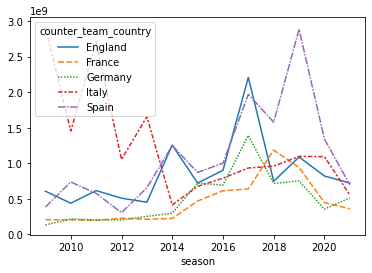

In [3]:
Big_five=['England','Italy','Spain','Germany','France']
df_fee_europe=df[df['dir']=='in']
df_fee_europe=df_fee_europe[df_fee_europe['counter_team_country'].isin(Big_five)]
fee_graph2=df_fee_europe.groupby(by=['season','counter_team_country']).sum()['transfer_fee_amnt']
sns.lineplot(data=fee_graph2.unstack())

Most buying countries from England among big leagues by year 

<AxesSubplot:xlabel='season'>

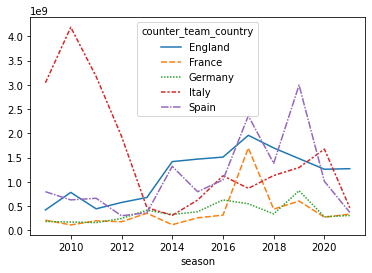

In [4]:
df_fee_europe=df[df['dir']=='left']
df_fee_europe=df_fee_europe[df_fee_europe['counter_team_country'].isin(Big_five)]
fee_graph2=df_fee_europe.groupby(by=['season','counter_team_country']).sum()['transfer_fee_amnt']
sns.lineplot(data=fee_graph2.unstack())

Most selling continent to England among rest of the world by year 

<AxesSubplot:xlabel='season'>

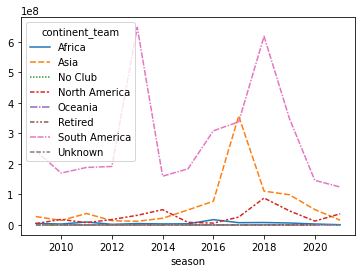

In [6]:
import seaborn as sns
df_fee=df[df['dir']=='in']
df_fee=df_fee.groupby(by=['season','continent_team']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack().drop(['Europe','Ban'],axis=1))

Most buying continents from England among rest of the world by year 

<AxesSubplot:xlabel='season'>

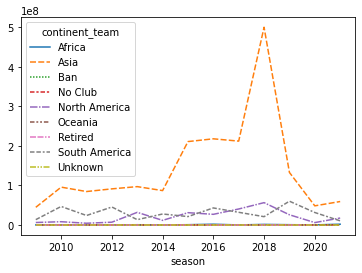

In [8]:
import seaborn as sns
df_fee=df[df['dir']=='left']
df_fee=df_fee.groupby(by=['season','continent_team']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack().drop(['Europe'],axis=1))

Difference between in and out players fee by year

<AxesSubplot:xlabel='season'>

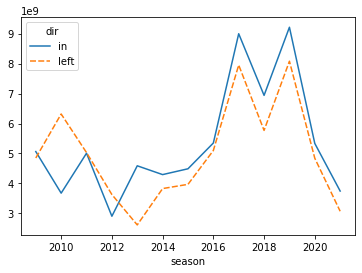

In [9]:
df_fee=df.groupby(by=['season','dir']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack())

Sum of fees by player age

<AxesSubplot:xlabel='player_age'>

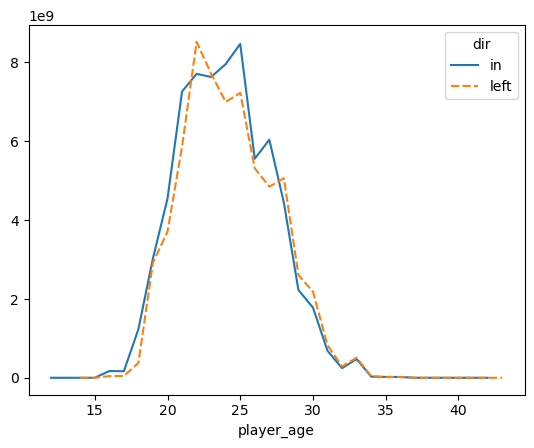

In [8]:
df_fee=df[df['player_age']<100]
df_fee=df_fee.groupby(by=['player_age','dir']).sum()['transfer_fee_amnt']
sns.lineplot(data=df_fee.unstack())

# Network code

This one is updated for every country I believe

In [9]:
G = nx.MultiDiGraph()
for index, row in df.iterrows():
    #if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
        #if row['team_name'] not in G.nodes():
            #G.add_node(row['team_name'], league=row['team_country'],continent='England')
    if row['counter_team_name'] not in G.nodes():
        G.add_node(row['counter_team_name'], league=row['counter_team_country'],continent=row['continent_team'])
for index, row in df.iterrows():
    #if row['team_country'] == 'England' or row['counter_team_country'] == 'England':
    if math.isnan(row['transfer_fee_amnt']):
        tmpfee = 0
    else:
        tmpfee = row['transfer_fee_amnt']
    if row['dir'] == 'in':
        G.add_edge(row['counter_team_name'],row['team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])
    else:
        G.add_edge(row['team_name'],row['counter_team_name'], player = row['player_name'], fee = tmpfee,nationality=row['player_nation'],continent_player=row['continent_player'])

In [12]:
tmpset = set(nx.get_node_attributes(G, 'league').values())

In [13]:
inthash = dict()
counter = 1
for i in tmpset:
    inthash[i] = counter
    counter+=1

In [16]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.1,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
#colors = [inthash[nx.get_node_attributes(G, 'league')[i]]/len(tmpset) for i in G.nodes()]
#colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'blue' for i in G.nodes()]
#plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
#nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)
#txt="Our graph plotted with forceatlas, colours being worlds red=marvel, blue=dc and nodesize being based on node degree"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
#plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:39<00:00, 12.58it/s]

BarnesHut Approximation  took  23.06  seconds
Repulsion forces  took  132.53  seconds
Gravitational forces  took  0.37  seconds
Attraction forces  took  0.34  seconds
AdjustSpeedAndApplyForces step  took  1.42  seconds


In [ ]:
# color_map = nx.get_node_attributes(G,'continent')
# for key in color_map:
#     if color_map[key] == 'England':
#         color_map[key] = 'red'
#     elif color_map[key] == 'Europe':
#         color_map[key] = 'blue'
#     elif color_map[key] == 'Africa':
#         color_map[key] = 'yellow'
#     elif color_map[key] == 'Asia':
#         color_map[key] = 'green'
#     elif color_map[key] == 'North America':
#         color_map[key] = 'pink'
#     elif color_map[key] == 'Oceania':
#         color_map[key] = 'brown'
#     elif color_map[key] == 'South America':
#         color_map[key] = 'purple'
#     else:
#         color_map[key] = 'gray'
# contcolor = [color_map.get(node) for node in G.nodes()]
# plt.figure(figsize=(16,16)) 
# nx.draw(G, pos=positions, node_color=contcolor, edge_color='black', arrows=True, arrowsize=10, node_size=35)

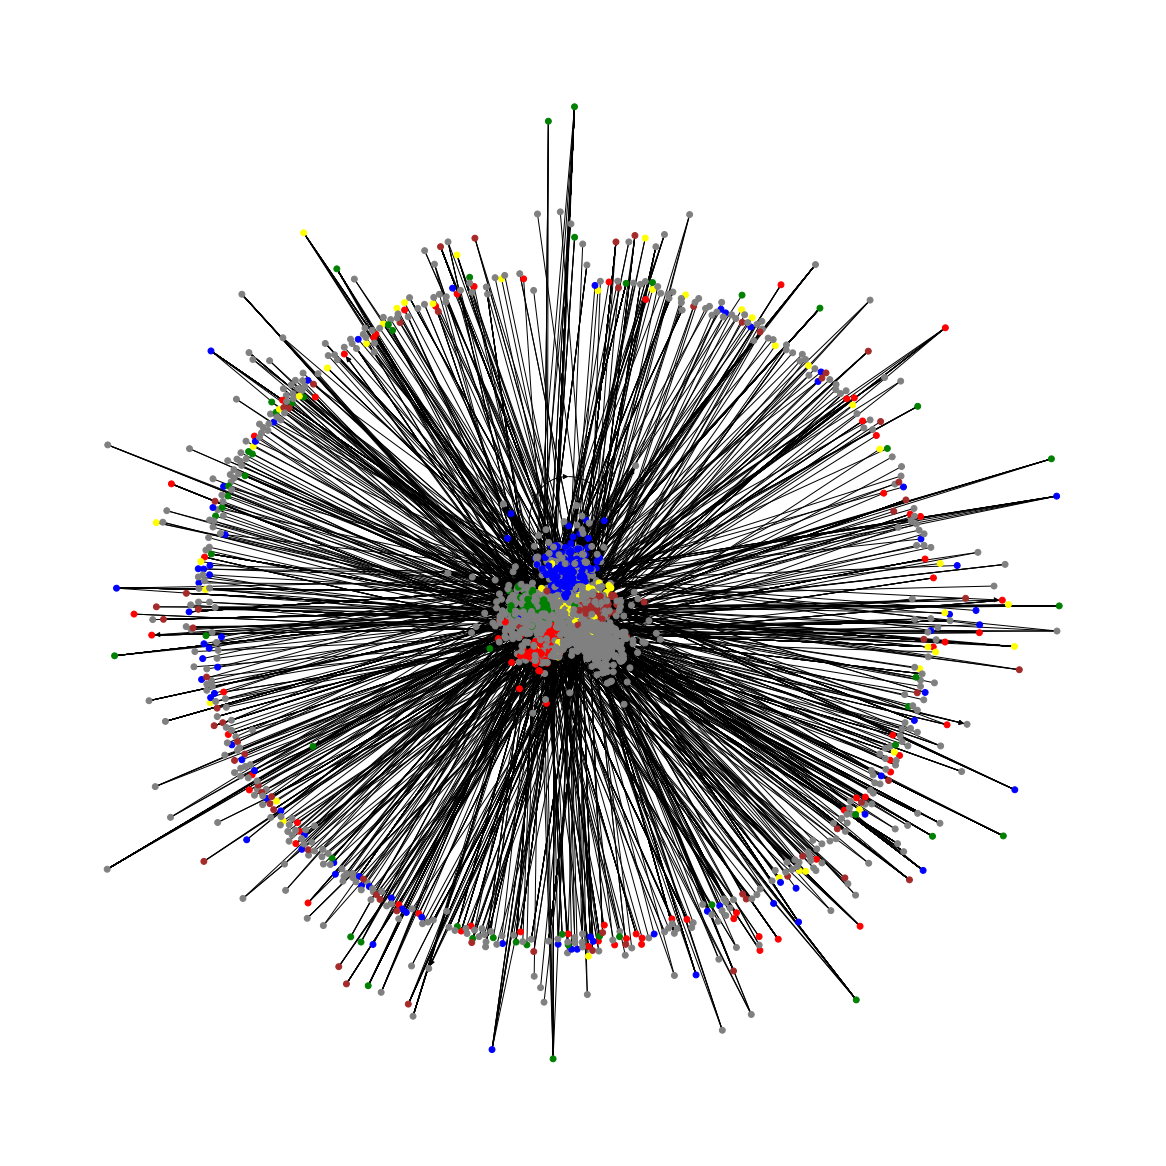

In [17]:
colors = ['red' if nx.get_node_attributes(G, 'league')[i] == 'England' else 'yellow' if nx.get_node_attributes(G, 'league')[i] == 'Spain'
          else 'blue' if nx.get_node_attributes(G, 'league')[i] == 'Italy' else 'green' if nx.get_node_attributes(G, 'league')[i] == 'Germany' 
          else 'brown' if nx.get_node_attributes(G, 'league')[i] == 'France' else 'gray' for i in G.nodes()]
plt.figure(figsize=(16,16)) 
#plt.axis([-1500, 1500, -1500, 1500])
nx.draw(G, pos=positions, node_color=colors, edge_color='black', arrows=True, arrowsize=10, node_size=35)

In [18]:
nx.write_gexf(G, 'wip.gexf')

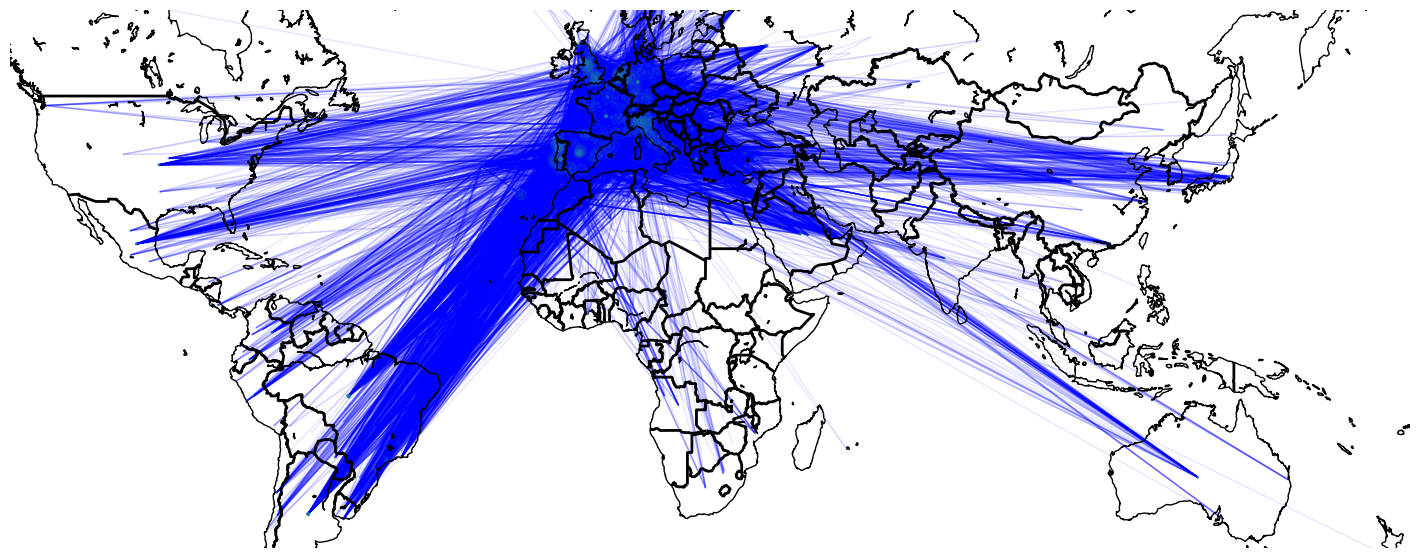

In [10]:
plt.figure(figsize = (14,12))
m = Basemap(projection='merc',llcrnrlon=-130,llcrnrlat=-40,urcrnrlon=180, 
urcrnrlat=60, lat_ts=0, resolution='l',suppress_ticks=True)

mx, my = m(df['Longitude_counter_team'].values,df['Latitude_counter_team'].values)
pos = {}
for count, elem in enumerate (df['counter_team_name']):
    pos[elem] = (mx[count], my[count])
    
d = dict(G.degree)
nx.draw(G, pos = pos, edge_color='blue', alpha=0.1, arrows = False,node_size=[v * 0.1 for v in d.values()])
m.drawcountries(linewidth = 2)
m.drawcoastlines(linewidth=1)
plt.savefig("map.png", dpi = 300)
plt.show()

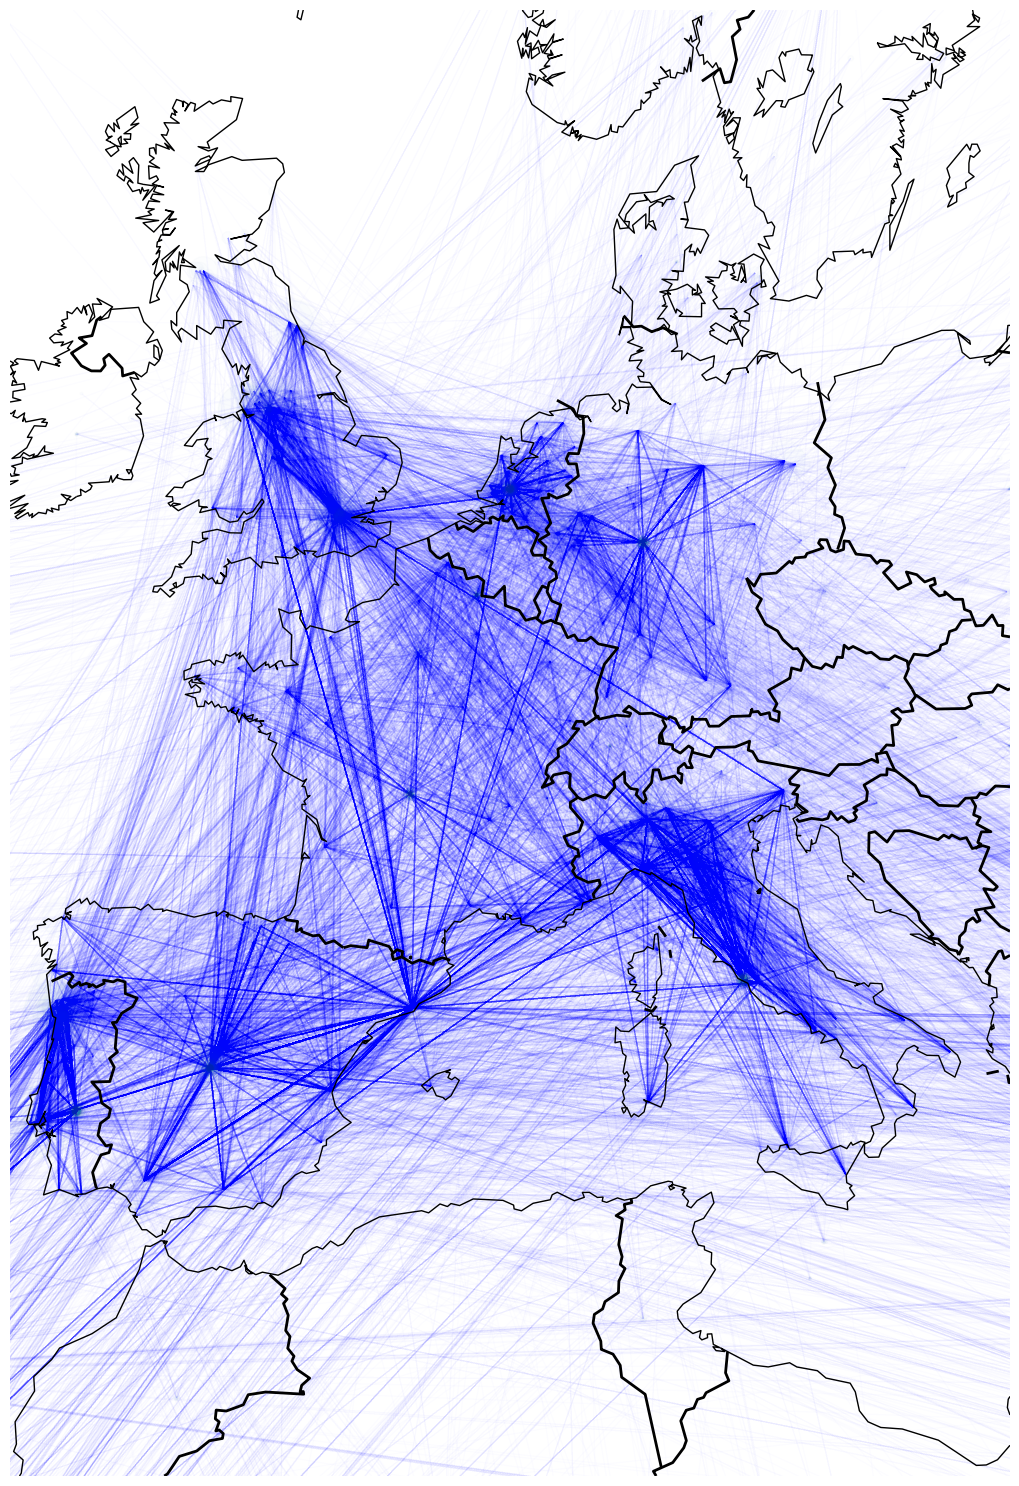

In [11]:
plt.figure(figsize = (10,20))
m = Basemap(projection='merc',llcrnrlon=-10,llcrnrlat=30,urcrnrlon=20, 
urcrnrlat=60, lat_ts=0, resolution='l',suppress_ticks=True)

mx, my = m(df['Longitude_counter_team'].values,df['Latitude_counter_team'].values)
pos = {}
for count, elem in enumerate (df['counter_team_name']):
    pos[elem] = (mx[count], my[count])
    
d = dict(G.degree)
nx.draw(G, pos = pos, edge_color='blue', alpha=0.01, arrows = False,node_size=[v * 2 for v in d.values()])
m.drawcountries(linewidth = 2)
m.drawstates(linewidth = 0.9)
m.drawcoastlines(linewidth=1)
plt.savefig("map_England.png", dpi = 300)
plt.show()


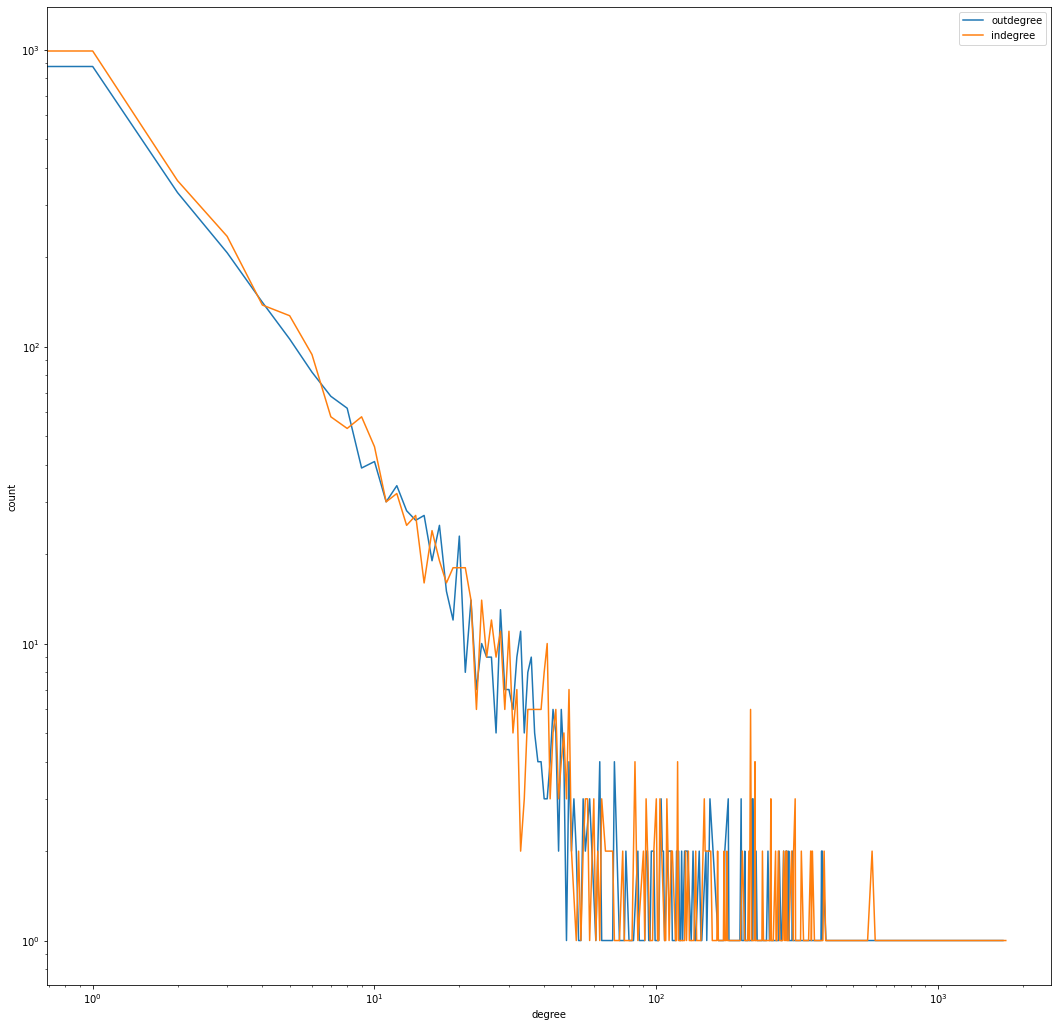

In [26]:
outdegree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
indegree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
fig = plt.figure("Degree distribution of football transfers graph", figsize=(18, 18))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('count')
plt.plot(*np.unique(outdegree_sequence, return_counts=True), label='outdegree')
plt.plot(*np.unique(indegree_sequence, return_counts=True), label='indegree')
plt.legend()
plt.show()

In [45]:
diameter = nx.diameter(G.to_undirected())
print('diameter of the network (if undirected)', diameter)
print('average shortest path in the network', nx.average_shortest_path_length(G))

diameter of the network (if undirected) 5
average shortest path in the network 1.86590027456611


In [35]:
truth = 0
for i in range(10000):
    rs = random.choice(list(G.nodes()))
    friends = G.degree(rs)
    nb = G.neighbors(rs)
    avnb = 0
    for j in nb:
        avnb+=G.degree(j)
    avnb = avnb/friends
    if avnb > friends:
        truth+=1
print('friendship paradox holds true for',truth, 'out of 10000 trials')

friendship paradox holds true for 6403 out of 10000 trials


In [44]:
#average degree of network
print('average degree of our network:', np.mean(sorted((d for n, d in G.degree()), reverse=True)))
print('lnn of our network:', math.log(len(G.nodes())))

average degree of our network: 41.377666943751734
lnn of our network: 8.19118600464279


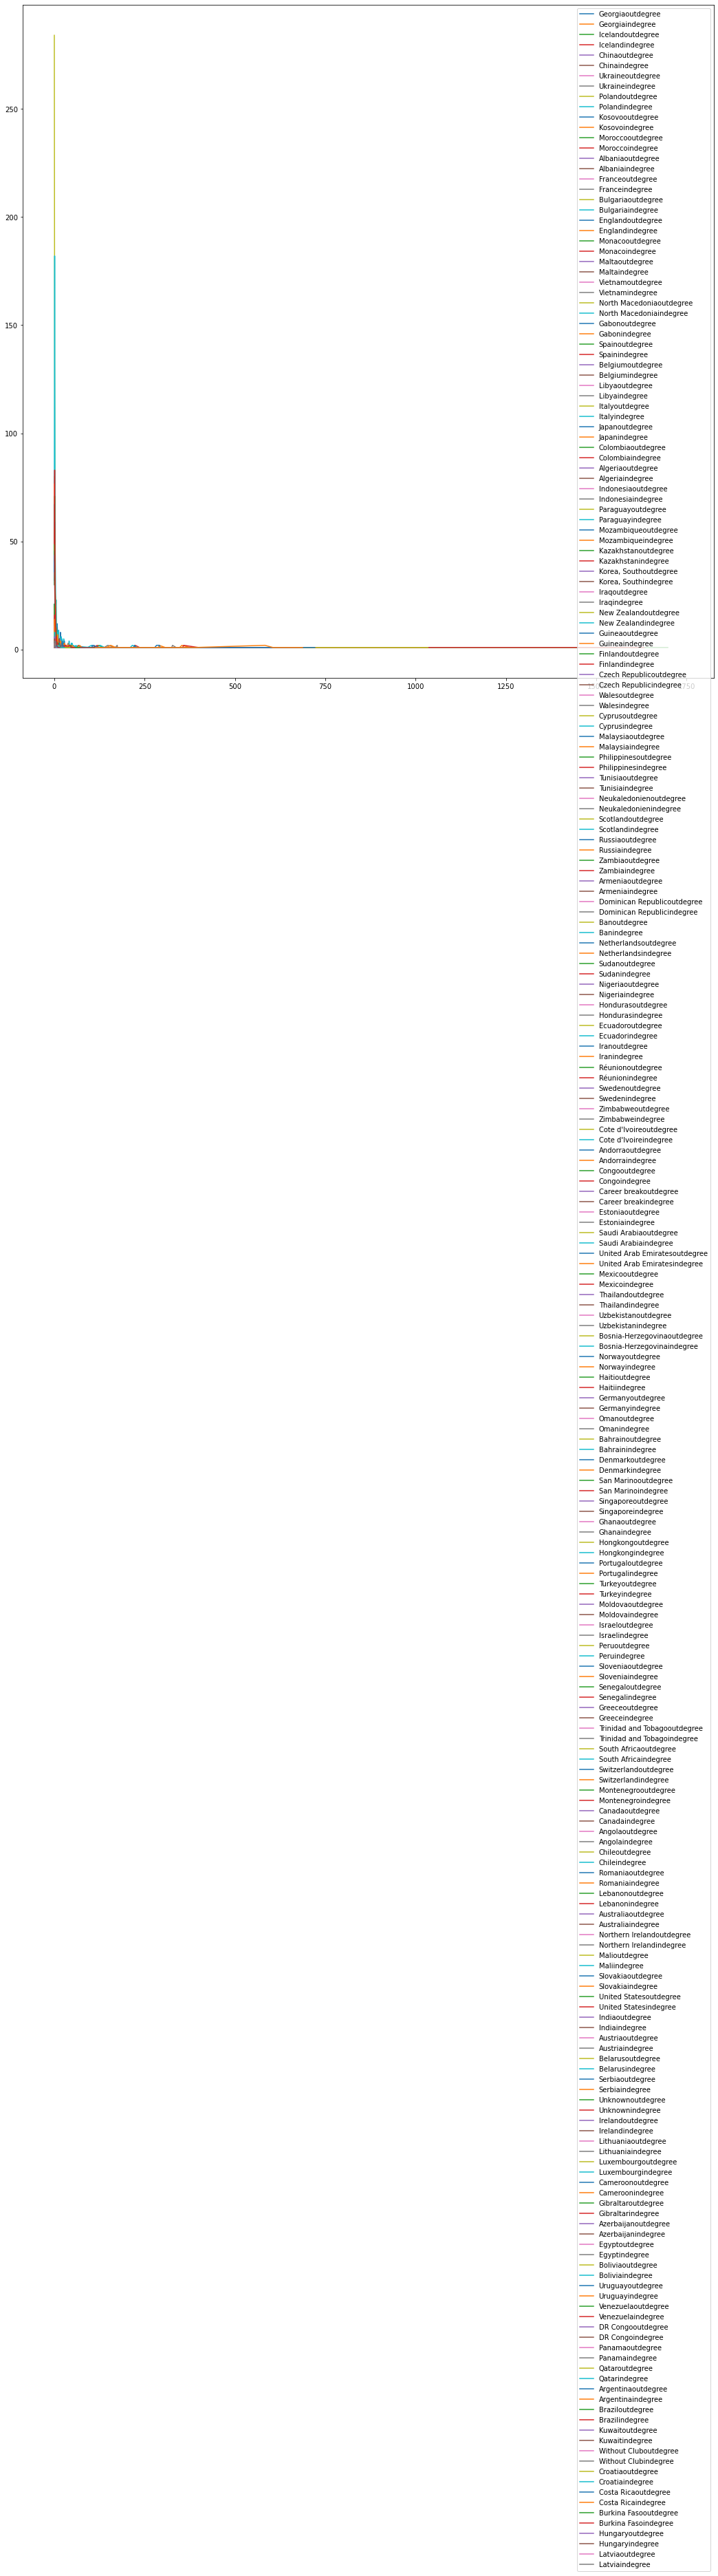

In [46]:
#nx.get_node_attributes(G, 'league')
fig = plt.figure("Degree of a random graph", figsize=(18, 18))
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    plt.plot(*np.unique(outdegree_sequence, return_counts=True), label=i+'outdegree')
    plt.plot(*np.unique(indegree_sequence, return_counts=True), label=i+'indegree')
plt.legend()
plt.show()

In [47]:
transferstocountry = dict()
transfersfromcountry = dict()
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    outdegree_sequence = sorted((d for n, d in G.out_degree() if n in tmpnodes), reverse=True)
    transfersfromcountry[i] = sum(outdegree_sequence)
    indegree_sequence = sorted((d for n, d in G.in_degree() if n in tmpnodes), reverse=True)
    transferstocountry[i] = sum(indegree_sequence)

In [72]:
sorted_ttc = sorted(transferstocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tfc = sorted(transfersfromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_ttc[0:10])
print('transfers from country')
print(sorted_tfc[0:10])

transfers to country
[('Italy', 14387), ('England', 10838), ('Spain', 10318), ('Portugal', 9616), ('France', 6940), ('Germany', 6731), ('Netherlands', 6277), ('Without Club', 1738), ('Brazil', 891), ('Turkey', 756)]
transfers from country
[('Italy', 15664), ('England', 10627), ('Spain', 10421), ('Portugal', 9740), ('France', 7376), ('Germany', 6913), ('Netherlands', 6674), ('Brazil', 1117), ('Belgium', 629), ('Without Club', 536)]


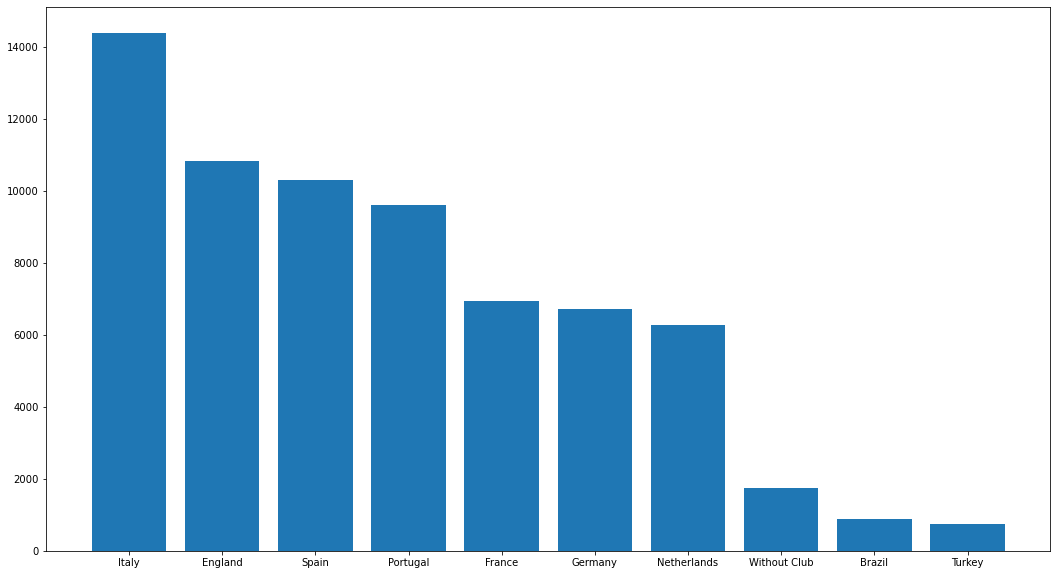

In [71]:
x = []
y = []
for i in sorted_ttc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players", figsize=(18, 10))
plt.bar(x,y)
plt.show()

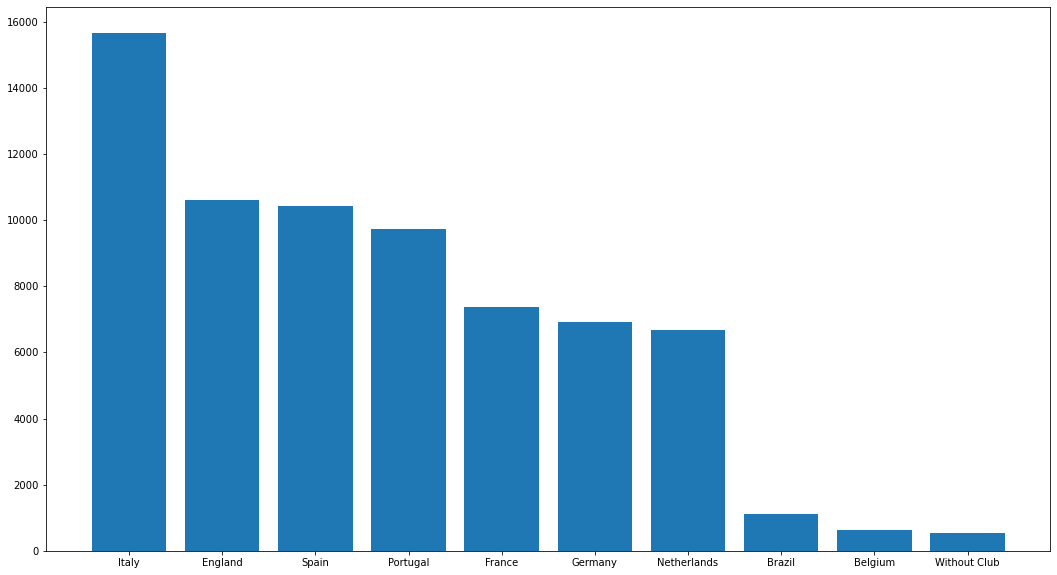

In [73]:
x = []
y = []
for i in sorted_tfc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [63]:
nx.get_edge_attributes(G, 'fee')
transferfeetocountry = dict()
transferfeefromcountry = dict()
for i in tmpset:
    tmpnodes = [x for x,y in G.nodes(data=True) if y['league']==i]
    tmpfrom = [z['fee'] for f, t, z in G.edges(data=True) if f in tmpnodes]
    transferfeefromcountry[i] = sum(tmpfrom)
    tmpto = [z['fee'] for f, t, z in G.edges(data=True) if t in tmpnodes]
    transferfeetocountry[i] = sum(tmpto)

In [64]:
counter = 0
for x,y,z in G.edges(data=True):
    counter+=1

In [65]:
sorted_tftc = sorted(transferfeetocountry.items(), key=lambda x:x[1], reverse=True)
sorted_tffc = sorted(transferfeefromcountry.items(), key=lambda x:x[1], reverse=True)
print('transfers to country')
print(sorted_tftc[1:11])
print('transfers from country')
print(sorted_tffc[1:11])

transfers to country
[('England', 33416719000.0), ('Spain', 31060880000.0), ('Germany', 11856664000.0), ('France', 11770933000.0), ('Portugal', 2325648000.0), ('Netherlands', 1370760000.0), ('Russia', 1164650000.0), ('China', 949365000.0), ('Turkey', 494276000.0), ('Brazil', 290855000.0)]
transfers from country
[('Spain', 29081128000.0), ('England', 21077994000.0), ('Germany', 12852060000.0), ('France', 11955716000.0), ('Portugal', 6680004000.0), ('Netherlands', 5383625000.0), ('Brazil', 2514886000.0), ('Belgium', 1012310000.0), ('Argentina', 761645000.0), ('Russia', 563109000.0)]


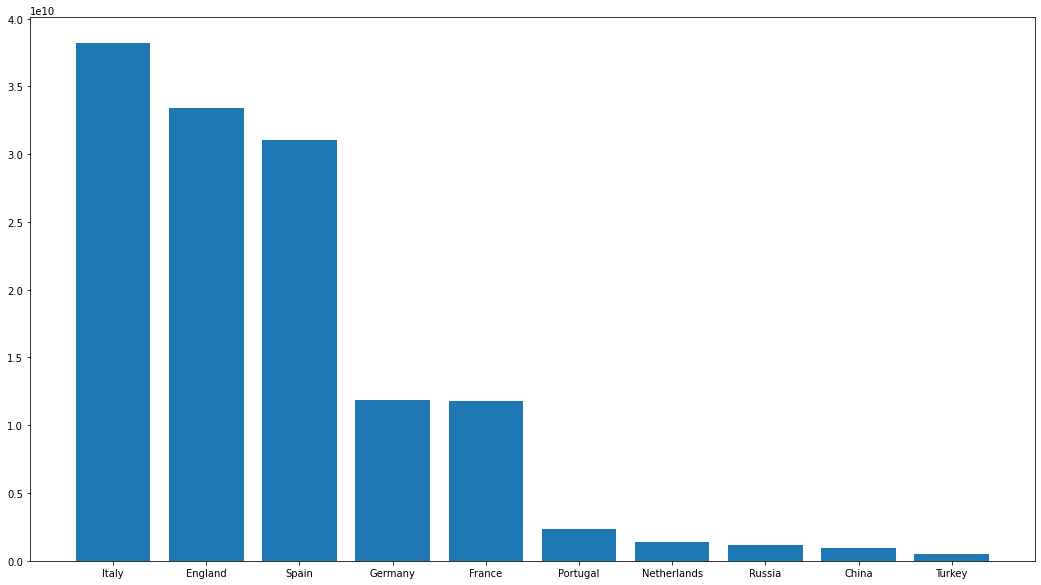

In [66]:
x = []
y = []
for i in sorted_tftc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries buying players by fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()

In [55]:
print(transferfeefromcountry['Spain'])
print(transferfeefromcountry['Italy'])

29081128000.0
37593332000.0


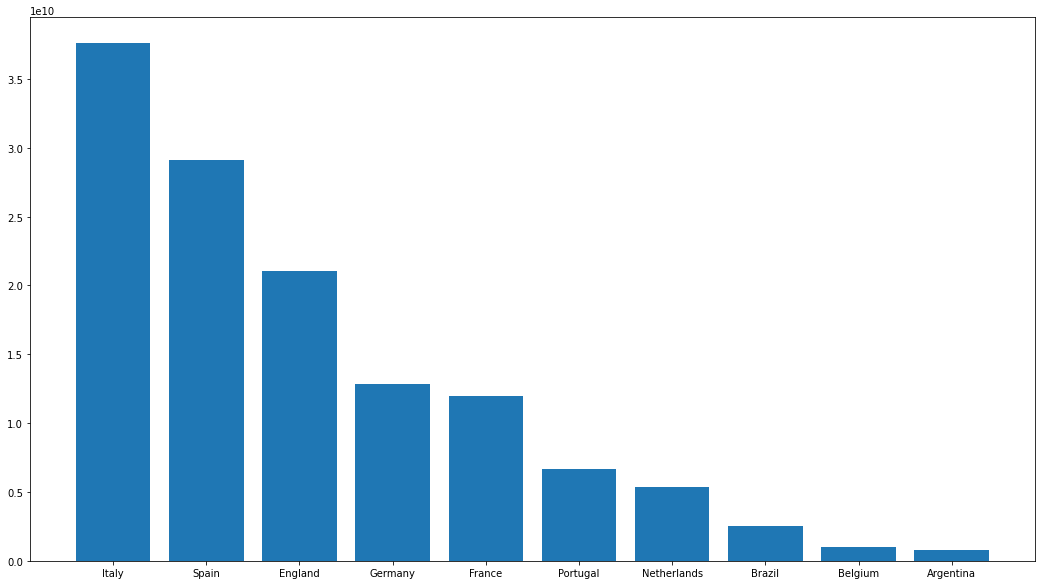

In [68]:
x = []
y = []
for i in sorted_tffc[0:10]:
    x.append(i[0])
    y.append(i[1])
fig = plt.figure("Top 10 countries selling players by fee", figsize=(18, 10))
plt.bar(x,y)
plt.show()

# Text Analysis

This is the distribution for the sentiment score for clubs

C:\Users\Paulo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='compound', ylabel='Density'>

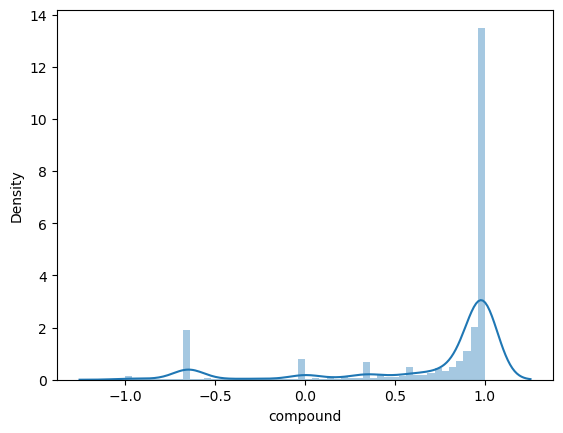

In [12]:
sns.distplot(df_clubs['compound']) #Histogram on sentiment values

In [13]:
df_players.dropna(subset=['market_val_amnt'],inplace=True)
df_players=df_players[df_players['dir']=='in']
df_teams=df_players.groupby(by=['team_id']).sum()
df_teams.reset_index(inplace=True)
df_teams=df_teams[['team_id','market_val_amnt']]

In [14]:
df_clubs2=df_clubs.copy()
df_clubs2=df_clubs2.merge(df_teams,right_on=df_teams.index,left_on='Transfermarkt_team_ID',how='left')

In [15]:
df_clubs2.dropna(subset='market_val_amnt',inplace=True)
df_clubs2['lenght']=df_clubs2['WikiContent'].str.len()
df_clubs2['product']=df_clubs2['lenght']*df_clubs2['compound']

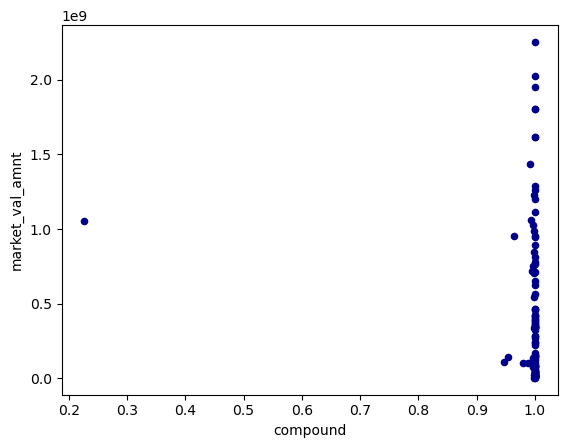

In [16]:
ax1 = df_clubs2.plot.scatter(x='compound',
                       y='market_val_amnt',
                       c='DarkBlue')

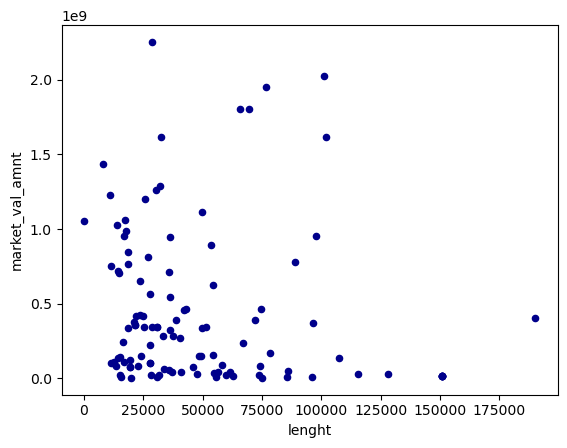

In [17]:
ax1 = df_clubs2.plot.scatter(y='market_val_amnt',
                       x='lenght',
                       c='DarkBlue')

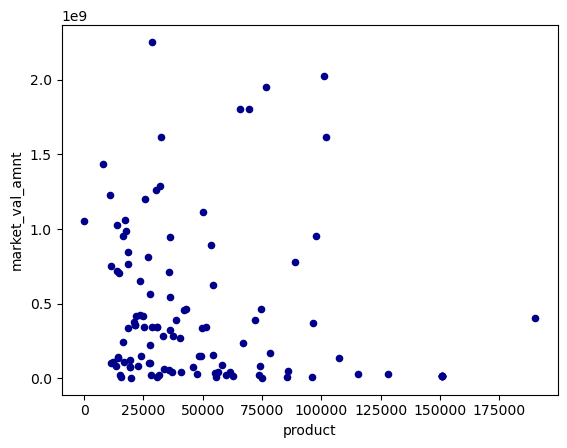

In [18]:
ax1 = df_clubs2.plot.scatter(y='market_val_amnt',
                       x='product',
                       c='DarkBlue')

In [19]:
import community
h=G
G=h.to_undirected()
partition = community.best_partition(G)
print('We have found a total of %s communities'%(max(partition.values())+1))

We have found a total of 7 communities


In [20]:
df_copy=df.copy()
#df_copy=df_copy[['counter_team_id','counter_team_name']]
df_copy['community']=df_copy.counter_team_name.map(partition)

In [21]:
df_clubs3=df_clubs.copy()
df_clubs3.dropna(subset='Transfermarkt_team_ID',inplace=True)
df_clubs3['Transfermarkt_team_ID']=df_clubs3['Transfermarkt_team_ID'].astype(int)
df_copy['counter_team_id']=df_copy['counter_team_id'].astype(int)

In [22]:
df_clubs3=df_clubs3.merge(df_copy,left_on='Transfermarkt_team_ID',right_on='counter_team_id',how='left')
df_clubs3.dropna(subset=['community'],inplace=True)
df_clubs3.drop_duplicates(subset='Transfermarkt_team_ID',inplace=True)
df_clubs3['size'] = df_clubs3['community'].apply(lambda x: (df_clubs3['community'] == x).sum())
df_clubs3.sort_values(by=['size'], ascending=False)

Unnamed: 0_x                                  club  \
47972          1714  http://www.wikidata.org/wiki/Q591746   
39083           587  http://www.wikidata.org/wiki/Q634829   
55007          2508  http://www.wikidata.org/wiki/Q856790   
55174          2522  http://www.wikidata.org/wiki/Q862851   
39392           626  http://www.wikidata.org/wiki/Q643338   
...             ...                                   ...   
37765           453  http://www.wikidata.org/wiki/Q464775   
37776           457  http://www.wikidata.org/wiki/Q472752   
44232          1266  http://www.wikidata.org/wiki/Q179075   
37837           474  http://www.wikidata.org/wiki/Q479351   
42389           916  http://www.wikidata.org/wiki/Q160530   

                  clubLabel                                     venue  \
47972             FK Inđija   http://www.wikidata.org/entity/Q4457040   
39083    G.D. Estoril Praia   http://www.wikidata.org/entity/Q1370647   
55007   CS Gaz Metan Mediaș   http://www.wikidata.org/entity/Q1322113   
55174           Foolad F.C.   http://www.wikidata.org/entity/Q5555191   
39392              Cobreloa  http://www.wikidata.org/entity/Q21044371   
...                     ...                                       ...   
37765               FC Thun    http://www.wikidata.org/entity/Q241022   
37776  Changchun Yatai F.C.   http://www.wikidata.org/entity/Q2619193   
44232        FC Dynamo Kyiv    http://www.wikidata.org/entity/Q183529   
37837       SV Darmstadt 98    http://www.wikidata.org/entity/Q878622   
42389         VfL Osnabrück    http://www.wikidata.org/entity/Q265199   

                                venueLabel                       coordinates  \
47972                       Inđija Stadium                Point(20.09 45.05)   
39083      Estádio António Coimbra da Mota              Point(-9.406 38.716)   
55007                  Stadionul Gaz Metan         Point(24.35275 46.172583)   
55174                       Ghadir Stadium        Point(48.669167 31.320278)   
39392          Estadio Zorros del Desierto  Point(-68.92055556 -22.46027778)   
...                                    ...                               ...   
37765                      Stockhorn Arena         Point(7.606075 46.744817)   
37776             Development Area Stadium       Point(125.390597 43.836881)   
44232  Olimpiyskiy National Sports Complex  Point(30.521666666 50.433333333)   
37837             Stadion am Böllenfalltor         Point(8.672222 49.857778)   
42389         Stadion an der Bremer Brücke         Point(8.071111 52.280833)   

        Longitude   Latitude  Transfermarkt_team_ID  \
47972   20.090000  45.050000                  11044   
39083   -9.406000  38.716000                   1465   
55007   24.352750  46.172583                   8104   
55174   48.669167  31.320278                   6076   
39392  -68.920556 -22.460278                   9103   
...           ...        ...                    ...   
37765    7.606075  46.744817                    938   
37776  125.390597  43.836881                   4768   
44232   30.521667  50.433333                    338   
37837    8.672222  49.857778                    105   
42389    8.071111  52.280833                     81   

                        headquarters_location  ...  \
47972  http://www.wikidata.org/entity/Q309341  ...   
39083  http://www.wikidata.org/entity/Q193305  ...   
55007  http://www.wikidata.org/entity/Q374465  ...   
55174  http://www.wikidata.org/entity/Q170366  ...   
39392    http://www.wikidata.org/entity/Q3685  ...   
...                                       ...  ...   
37765   http://www.wikidata.org/entity/Q68978  ...   
37776   http://www.wikidata.org/entity/Q92161  ...   
44232    http://www.wikidata.org/entity/Q1899  ...   
37837    http://www.wikidata.org/entity/Q2973  ...   
42389    http://www.wikidata.org/entity/Q2916  ...   

                             sentiment_club_counter_team  \
47972  {'neg': 0.009, 'neu': 0.906, 'pos': 0.085, 'co...   
39083 

In [23]:
df_texts=df_clubs3.groupby(['community'])['WikiContent'].apply(' '.join).reset_index()

In [24]:
# Visualizing communities and sizes
for i in range(max(partition.values())+1):
    print("community %s has size %s"%(i+1,sum(1 for v in partition.values() if v == i)))

community 1 has size 372
community 2 has size 307
community 3 has size 504
community 4 has size 770
community 5 has size 353
community 6 has size 477
community 7 has size 826


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english') # Define tfidf
tfidf_matrix = tf.fit_transform(df_texts['WikiContent'].values) # Fit and transform the TF-IDF for all texts present in every community

In [26]:
test = np.zeros((max(partition.values())+1))
for i in partition.values():
    test[i] +=1
ind = np.argpartition(test, 6)[-7:]

Top 10 words according to TF-IDF community number 1 
                    tfidf
league           0.376488
club             0.368137
football         0.330592
cup              0.202135
season           0.195166
fc               0.160509
city             0.136839
united           0.120766
news             0.110407
web              0.106420
team             0.105133
football league  0.104254
division         0.103908
player           0.094679

Distribution of the teams by country they belong
England          234
Scotland          20
Ireland           15
United States     11
Wales              7
Belgium            5
Turkey             4
Sweden             4
Denmark            3
Poland             3
Name: counter_team_country, dtype: int64

Wordcloud for community number 1 


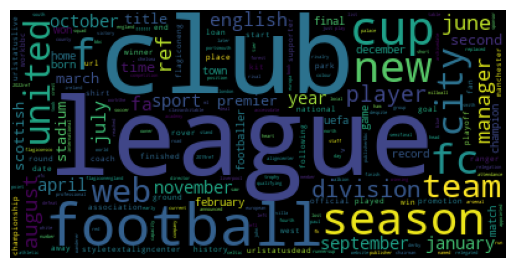

Top 10 words according to TF-IDF community number 2 
                         tfidf
club                  0.345241
styletextaligncenter  0.251022
league                0.250458
football              0.247263
cup                   0.196332
uefa                  0.192511
fc                    0.190882
season                0.179606
team                  0.149348
bundesliga            0.121282
champion              0.115331
june                  0.103303
player                0.095598
europa                0.083883

Distribution of the teams by country they belong
Germany           170
Austria            16
Switzerland        13
Czech Republic      7
Japan               6
Turkey              6
Poland              5
Norway              5
Sweden              5
United States       5
Name: counter_team_country, dtype: int64

Wordcloud for community number 2 


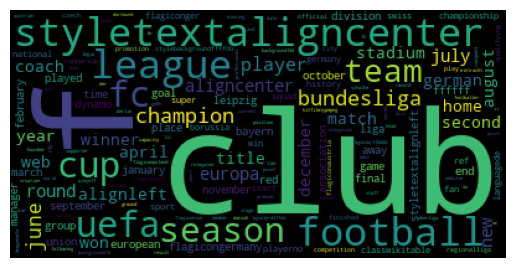

Top 10 words according to TF-IDF community number 3 
                   tfidf
club            0.307564
league          0.272401
football        0.237709
divisie         0.203612
knvb            0.202810
cup             0.186145
season          0.174199
eerste          0.171298
eerste divisie  0.169120
uefa            0.155233
round           0.147674
team            0.141667
aligncenter     0.125604
eredivisie      0.124019

Distribution of the teams by country they belong
Netherlands      195
Belgium           23
Germany           18
Sweden            13
United States     12
Hungary            9
Israel             8
Poland             8
Norway             8
Serbia             7
Name: counter_team_country, dtype: int64

Wordcloud for community number 3 


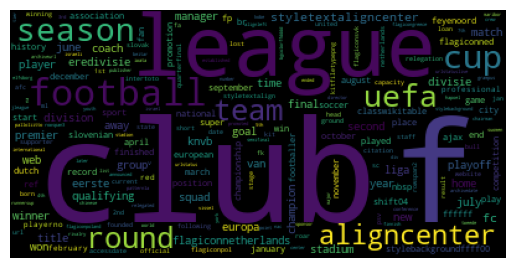

Top 10 words according to TF-IDF community number 4 
                         tfidf
serie                 0.402896
club                  0.398206
football              0.271794
season                0.213347
league                0.156301
team                  0.124943
player                0.124873
june                  0.113883
cup                   0.109893
flagiconita           0.100934
fc                    0.093724
uefa                  0.089035
styletextaligncenter  0.087705
italian               0.080845

Distribution of the teams by country they belong
Italy            450
Switzerland       15
Romania           15
Malta             11
Brazil            10
Spain              9
United States      9
Argentina          8
Croatia            7
Belgium            6
Name: counter_team_country, dtype: int64

Wordcloud for community number 4 


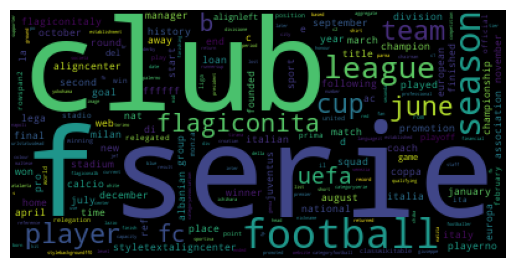

Top 10 words according to TF-IDF community number 5 
                tfidf
club         0.359332
league       0.210055
football     0.186709
copa         0.169088
cup          0.163700
season       0.163532
del          0.148211
la           0.147594
aligncenter  0.142824
segunda      0.138422
copa del     0.137531
team         0.133340
uefa         0.114091
división     0.113024

Distribution of the teams by country they belong
Spain        157
Argentina     14
Brazil        13
Mexico        13
China         11
Turkey        10
Greece         8
Colombia       7
Uruguay        7
Chile          6
Name: counter_team_country, dtype: int64

Wordcloud for community number 5 


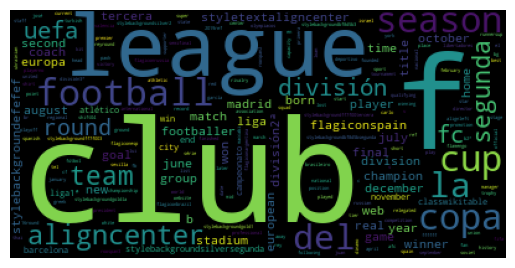

Top 10 words according to TF-IDF community number 6 
                         tfidf
club                  0.446932
football              0.270160
league                0.243850
season                0.206645
cup                   0.183213
team                  0.158684
uefa                  0.142308
fc                    0.135320
aligncenter           0.124152
division              0.117848
styletextaligncenter  0.110448
player                0.104076
ligue                 0.098091
champion              0.095854

Distribution of the teams by country they belong
France         196
Belgium         22
Greece          13
Turkey          11
Denmark          9
Romania          8
England          7
Switzerland      7
Bulgaria         6
Morocco          6
Name: counter_team_country, dtype: int64

Wordcloud for community number 6 


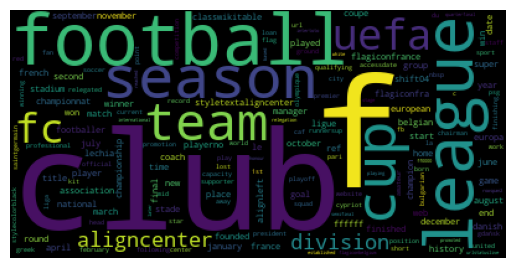

Top 10 words according to TF-IDF community number 7 
                         tfidf
club                  0.333609
league                0.262232
football              0.251107
styletextaligncenter  0.205387
aligncenter           0.157416
cup                   0.152143
uefa                  0.145327
season                0.141533
team                  0.129894
fc                    0.129701
round                 0.126229
primeira              0.103696
campeonato            0.102372
home                  0.097163

Distribution of the teams by country they belong
Portugal     247
Brazil       186
Argentina     17
Russia        13
Spain         13
Japan         12
Romania       12
Cyprus        12
Greece        11
Paraguay      10
Name: counter_team_country, dtype: int64

Wordcloud for community number 7 


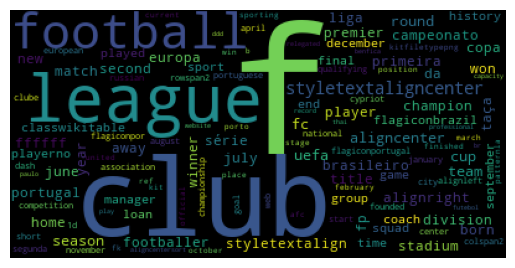

In [27]:
df_copy.drop_duplicates(subset='counter_team_id',inplace=True)
# We have already sorted the text, so the first 10 string correspond to the top 10 communities by size
for i in ind:#range(10):
    print("Top 10 words according to TF-IDF community number %s " %(i+1))
    vector_tfidfvectorizer = tfidf_matrix[i] # i correspond to the community number
    df_ = pd.DataFrame(vector_tfidfvectorizer.T.todense(), index=tf.get_feature_names_out(), columns=["tfidf"]) # Transform to dataframe in order to visualize
    print(df_.sort_values(by=["tfidf"],ascending=False)[0:14]) # Print top 10 words
    print('\nDistribution of the teams by country they belong')
    print(df_copy[df_copy['community']==i]['counter_team_country'].value_counts()[0:10])
    print("\nWordcloud for community number %s " %(i+1))
    wordcloud = WordCloud(collocations = False, stopwords=_stop_words.ENGLISH_STOP_WORDS).generate(df_texts['WikiContent'].loc[i])
    #wordcloud = WordCloud(collocations = False, stopwords=_stop_words.ENGLISH_STOP_WORDS).generate(texts[i]) # Generate wordcloud to visualize
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Let's have a look at the most "loved" clubs. We can see that among them, we have a lot of the most powerful clubs of Europe, such as "Real Madrid" and "Borussia Dortmund"

In [28]:
print("In total we have {} clubs with the highest sentiment score, out of {} total clubs in the dataframe".format(len(df_clubs[df_clubs['compound']==1]),len(df_clubs)))
df_clubs.sort_values(by='compound',ascending=False)

In total we have 169 clubs with the highest sentiment score, out of 9560 total clubs in the dataframe


Unnamed: 0                                    club  \
405          405      http://www.wikidata.org/wiki/Q8682   
2591        2591    http://www.wikidata.org/wiki/Q912225   
125          125     http://www.wikidata.org/wiki/Q41420   
7277        7277   http://www.wikidata.org/wiki/Q1786860   
1716        1716    http://www.wikidata.org/wiki/Q592241   
...          ...                                     ...   
7192        7192   http://www.wikidata.org/wiki/Q7404667   
4176        4176   http://www.wikidata.org/wiki/Q2276413   
8359        8359  http://www.wikidata.org/wiki/Q16848527   
6532        6532   http://www.wikidata.org/wiki/Q6334727   
6954        6954   http://www.wikidata.org/wiki/Q7292796   

                                  clubLabel  \
405                          Real Madrid CF   
2591                              USM Alger   
125                       Borussia Dortmund   
7277                           Stade Malien   
1716                           Iraklis F.C.   
...                                     ...   
7192                   Salinas Valley Samba   
4176                         Virtus Entella   
8359     Reading F.C. Under-21s and Academy   
6532                         Ottawa Fury FC   
6954  Rangers F.C. Reserve and Youth squads   

                                        venue                 venueLabel  \
405    http://www.wikidata.org/entity/Q164027  Santiago Bernabéu Stadium   
2591  http://www.wikidata.org/entity/Q2023039        Omar Hamadi Stadium   
125    http://www.wikidata.org/entity/Q150928           Westfalenstadion   
7277  http://www.wikidata.org/entity/Q3496077           Stade du 26 Mars   
1716   http://www.wikidata.org/entity/Q472710       Kaftanzoglio Stadium   
...                                       ...                        ...   
7192  http://www.wikidata.org/entity/Q7974897    Watsonville High School   
4176  http://www.wikidata.org/entity/Q3967768            Stadio Comunale   
8359    http://www.wikidata.org/entity/Q31656           Madejski Stadium   
6532  http://www.wikidata.org/entity/Q1442809           TD Place Stadium   
6954  http://www.wikidata.org/entity/Q3328212                Murray Park   

                           coordinates   Longitude   Latitude  \
405           Point(-3.68835 40.45306)   -3.688350  40.453060   
2591         Point(3.048111 36.801055)    3.048111  36.801055   
125            Point(7.451667 51.4925)    7.451667  51.492500   
7277        Point(-7.921667 12.604444)   -7.921667  12.604444   
1716  Point(22.967002777 40.625497222)   22.967003  40.625497   
...                                ...         ...        ...   
7192           Point(-121.752 36.9133) -121.752000  36.913300   
4176            Point(9.33732 44.3156)    9.337320  44.315600   
8359  Point(-0.982777777 51.422222222)   -0.982778  51.422222   
6532     Point(-75.68365 45.398177777)  -75.683650  45.398178   
6954        Point(-4.304516 55.933193)   -4.304516  55.933193   

      Transfermarkt_team_ID                   headquarters_location  \
405                   418.0    http://www.wikidata.org/entity/Q2807   
2591                    NaN    http://www.wikidata.org/entity/Q3561   
125                    16.0    http://www.wikidata.org/entity/Q1295   
7277                    NaN    http://www.wikidata.org/entity/Q3703   
1716                    NaN   http://www.wikidata.org/entity/Q17151   
...                     ...                                     ...   
7192                    NaN                                     NaN   
4176                20519.0  http://www.wikidata.org/entity/Q266941   
8359                    NaN                                     NaN   
6532                    NaN    http://www.wikidata.org/entity/Q1930   
6954                    NaN                                     NaN   

     headquarters_locationLabel                                link  \
405                      Madrid                      Real_Madrid_CF   
2591                    Algiers

We're going to extract the top 100 words for the most loved and hated clubs

In [29]:
top_N = 100

a = df_clubs[df_clubs['compound']==1]['WikiContent'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

word_tokens = word_tokenize(b)

# Remove characters which have length less than 2  
without_single_chr = [word for word in word_tokens if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt_best = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

In [30]:
top_N = 100

a = df_clubs[df_clubs['compound']<-0.5]['WikiContent'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

word_tokens = word_tokenize(b)

# Remove characters which have length less than 2  
without_single_chr = [word for word in word_tokens if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt_worst = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

In [31]:
wordlist=[]
for best in rslt_best['Word'].unique():
    if best not in rslt_worst['Word'].unique():
        wordlist.append(best)
print('We have %s words that are in the Top 100 words for most loved clubs but not in the most hated: '%len(wordlist),wordlist)

We have 67 words that are in the Top 100 words for most loved clubs but not in the most hated:  ['champion', 'archiveurlhttpswebarchiveorgweb', 'archivedate', 'united', 'styletextaligncenter', 'title', 'uefa', 'final', 'july', 'city', 'september', 'october', 'won', 'new', 'november', 'time', 'december', 'january', 'winner', 'march', 'refcite', 'win', 'game', 'sport', 'goal', 'february', 'record', 'barcelona', 'super', 'home', 'coach', 'premier', 'european', 'national', 'championship', 'association', 'urlstatuslive', 'fan', 'scottish', 'history', 'end', 'liga', 'footballer', 'played', 'afc', 'world', 'competition', 'kit', 'born', 'madrid', 'cite', 'winning', 'following', 'refrefcite', 'urlstatusdead', 'squad', 'official', 'place', 'away', 'copa', 'europa', 'sydney', 'ground', 'real', 'victory', 'red', 'finished']


#### We can see that there are certain words that make sense that are there, such as 'champion', 'title', 'final'. We also have some that are mostly wikipedia common words such as 'archivedate' or 'styletextaligncenter'.

In [32]:
wordlist=[]
for worst in rslt_worst['Word'].unique():
    if worst not in rslt_best['Word'].unique():
        wordlist.append(worst)
print('We have %s words that are in the Top 100 words for most hated clubs but not in the most loves: '%len(wordlist),wordlist)

We have 67 words that are in the Top 100 words for most hated clubs but not in the most loves:  ['disambiguation', 'meshuggah', 'cloak', 'altering', 'zero', 'mathematical', 'concept', 'epnone', 'liturgy', 'piedmont', 'stylebackgroundff', 'dynamo', 'divisi', 'bfc', 'berlin', 'region', 'italian', 'set', 'province', 'language', 'political', 'christian', 'represented', 'thing', 'traditional', 'available', 'lack', 'nun', 'swedish', 'heavy', 'ninth', 'collection', 'hour', 'refer', 'music', 'band', 'expression', 'quantity', 'commune', 'affiliation', 'wiktionarynone', 'indefinite', 'pronoun', 'metal', 'dutch', 'turin', 'irreligion', 'religious', 'rejecting', 'candidate', 'none', 'nunn', 'srt', 'tercera', 'der', 'locationberlin', 'languagede', 'gmbh', 'stylebackgroundefefef', 'nat', 'union', 'ntsh', 'stylebackgroundcece', 'ffffff', 'east', 'patternla', 'leftarm']


In [33]:
wordlist=[]
for worst in rslt_worst['Word'].unique():
    if worst in rslt_best['Word'].unique():
        wordlist.append(worst)
print('We have %s words that are in the Top 100 words for most hated and also in the most loves: '%len(wordlist),wordlist)

We have 33 words that are in the Top 100 words for most hated and also in the most loves:  ['aligncenter', 'club', 'league', 'football', 'ref', 'date', 'playerno', 'season', 'accessdate', 'player', 'team', 'group', 'news', 'division', 'english', 'cup', 'alignright', 'alignleft', 'round', 'second', 'match', 'web', 'june', 'year', 'august', 'stadium', 'html', 'supporter', 'rowspan', 'april', 'colspan', 'soccer', 'manager']


## We can do the same for players

In [36]:
df_players.dropna(subset='WikiContent',inplace=True)
df_players['WikiContent']=df_players['WikiContent'].astype(str)
df_players['WikiContent']=df_players['WikiContent'].apply(text_processing)

C:\Users\Paulo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='compound', ylabel='Density'>

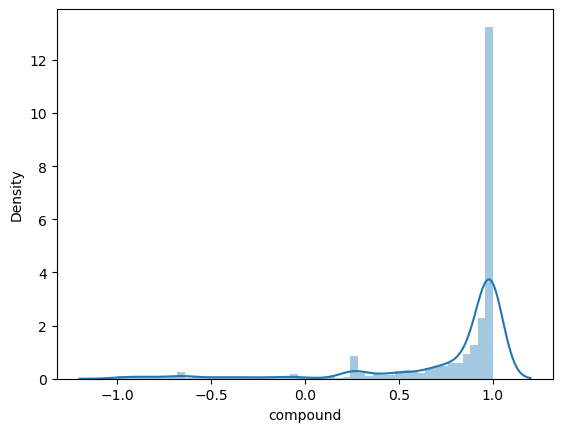

In [37]:
df_players.drop_duplicates(subset='player_id',inplace=True)
sns.distplot(df_players['compound']) #Histogram on sentiment values

Let's have a look at the most "loved" players. We can see that among them, we have a lot of the most famous player in Europe, such as "Dani Alves", "Cristiano Ronaldo", "Lionel Messi" among others.

On the other hand, the most "hated" players have been involved with crimes, such as, "Joey Barton", "Ched Evans", "Ricardo Centurión", among others

In [38]:
print("In total we have {} players with the highest sentiment score, out of {} total players in the dataframe".format(len(df_players[df_players['compound']==1]),len(df_players)))
df_players.sort_values(by='compound',ascending=False)

In total we have 119 players with the highest sentiment score, out of 9406 total players in the dataframe


Unnamed: 0 league  season window  team_id               team_name  \
33064       33064    IT1    2019      s      430          ACF Fiorentina   
33441       33441    IT1    2019      s     6195              SSC Napoli   
33311       33311    IT1    2019      s      506             Juventus FC   
1139         1139    GB1    2010      s      762        Newcastle United   
4579         4579    GB1    2013      w      631              Chelsea FC   
...           ...    ...     ...    ...      ...                     ...   
58448       58448    PO1    2017      s     1465        GD Estoril Praia   
43801       43801    FR1    2010      s      750  FC Sochaux-Montbéliard   
46816       46816    FR1    2015      s      995               FC Nantes   
25313       25313    IT1    2013      s      252               Genoa CFC   
1081         1081    GB1    2010      s      984    West Bromwich Albion   

      team_country dir  player_id           player_name  ...  is_retired  \
33064        Italy  in      22068         Franck Ribéry  ...       False   
33441        Italy  in     316889        Hirving Lozano  ...       False   
33311        Italy  in       5023      Gianluigi Buffon  ...       False   
1139       England  in      52570        Fraser Forster  ...       False   
4579       England  in     148455         Mohamed Salah  ...       False   
...            ...  ..        ...                   ...  ...         ...   
58448     Portugal  in     273455                 Abner  ...       False   
43801       France  in     127053           Rafaël Dias  ...       False   
46816       France  in      52246  Kolbeinn Sigthórsson  ...       False   
25313        Italy  in     230058     Ricardo Centurión  ...       False   
1081       England  in       6893         Gabriel Tamas  ...       False   

      transfer_id               association_football_player  \
33064     2616300      http://www.wikidata.org/entity/Q1918   
33441     2618892  http://www.wikidata.org/entity/Q17633812   
33311     2537963     http://www.wikidata.org/entity/Q68060   
1139       471862    http://www.wikidata.org/entity/Q348813   
4579      1007836   http://www.wikidata.org/entity/Q1354960   
...           ...                                       ...   
58448     1886983  http://www.wikidata.org/entity/Q17318558   
43801      443241   http://www.wikidata.org/entity/Q2006783   
46816     1275436    http://www.wikidata.org/entity/Q128936   
25313      943049    http://www.wikidata.org/entity/Q585136   
1081       419855    http://www.wikidata.org/entity/Q334484   

      Transfermarkt_player_ID  \
33064                 22068.0   
33441                316889.0   
33311                  5023.0   
1139                  52570.0   
4579                 148455.0   
...                       ...   
58448                273455.0   
43801                127053.0   
46816                 52246.0   
25313                230058.0   
1081                   6893.0   

                                             WikiContent  \
33064  pppc1 short descriptionfrench footballer born ...   
33441  short descriptionmexican footballer use dmy da...   
33311  short descriptionitalian footballer born 1978 ...   
1139   short descriptionenglish footballer use britis...   
4579   short descriptionegyptian footballer born 1992...   
...                                                  ...   
58448  short descriptionbrazilian footballer usesabne...   
43801  short descriptionbrazilian footballer peoplera...   
46816  short descriptionicelandic footballer icelandi...   
25313  short descriptionargentine footballer infobox ...   
1081   short descriptionromanian professional footbal...   

                                               sentiment    neg    neu    pos  \
33064  {'neg': 0.043, 'neu': 0.872, 'pos': 0.084, 'co...  0.043  0.872  0.084   
33441  {'neg': 0.027, 'neu': 0.875, 'pos': 0.098, 'co...  0.027  0.875  0.098   
33311  {'neg': 0.033, 'neu': 0.839, 'pos': 0.128, 'co...  0.033

In [39]:
df_players['lenght']=df_players['WikiContent'].str.len()
df_players['product']=df_players['lenght']*df_players['compound'] # We have multiplied the sentiment value by the market value of each player to find out if we can combine the correlation

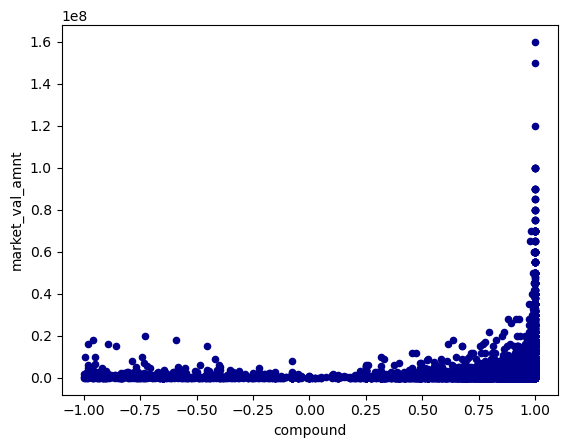

In [40]:
df__=df_players.groupby('player_id').mean()[['compound','market_val_amnt']].dropna(subset='market_val_amnt')
ax1 = df__.plot.scatter(x='compound',
                       y='market_val_amnt',
                       c='DarkBlue')

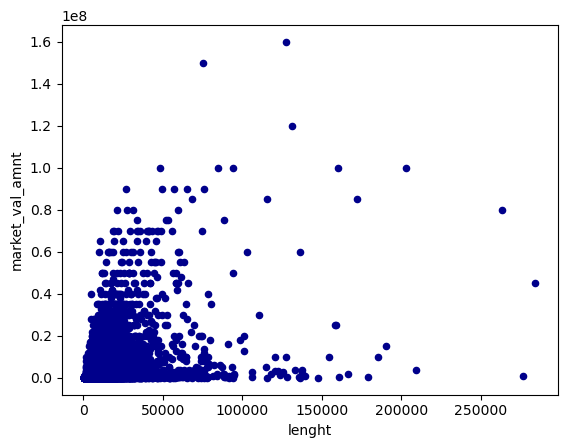

In [41]:
df__=df_players.groupby('player_id').mean()[['lenght','market_val_amnt']].dropna(subset='market_val_amnt')
ax1 = df__.plot.scatter(y='market_val_amnt',
                       x='lenght',
                       c='DarkBlue')

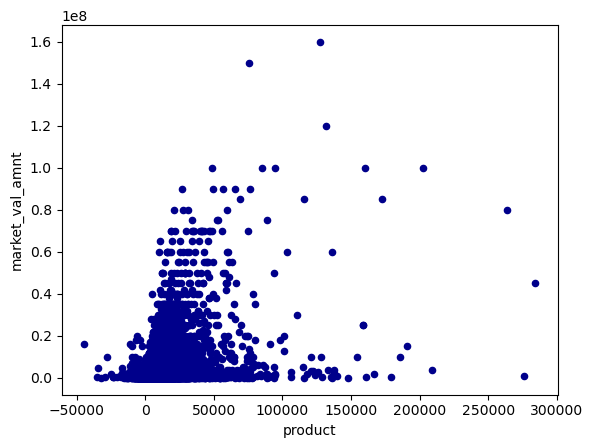

In [42]:
df__=df_players.groupby('player_id').mean()[['product','market_val_amnt']].dropna(subset='product')
ax1 = df__.plot.scatter(y='market_val_amnt',
                       x='product',
                       c='DarkBlue')

We're going to extract the top 100 words for the most loved and hated players

In [43]:
top_N = 100

a = df_players[df_players['compound']==1]['WikiContent'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

word_tokens = word_tokenize(b)

# Remove characters which have length less than 2  
without_single_chr = [word for word in word_tokens if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt_best = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

In [44]:
top_N = 100

a = df_players.sort_values(by='compound',ascending=True).iloc[0:100]['WikiContent'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

word_tokens = word_tokenize(b)

# Remove characters which have length less than 2  
without_single_chr = [word for word in word_tokens if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt_worst = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

In [45]:
wordlist=[]
for best in rslt_best['Word'].unique():
    if best not in rslt_worst['Word'].unique():
        wordlist.append(best)
print('We have %s words that are in the Top 100 words for most loved clubs but not in the most hated: '%len(wordlist),wordlist)

We have 43 words that are in the Top 100 words for most loved clubs but not in the most hated:  ['archiveurlhttpswebarchiveorgweb', 'united', 'fifa', 'champion', 'premier', 'madrid', 'manchester', 'websitebbc', 'final', 'second', 'real', 'time', 'best', 'chelsea', 'euro', 'liverpool', 'england', 'arsenal', 'score', 'victory', 'later', 'award', 'man', 'barcelona', 'group', 'won', 'scoring', 'urlstatuslive', 'new', 'record', 'home', 'european', 'named', 'minute', 'penalty', 'copa', 'bayern', 'away', 'urlstatusdead', 'urlhttpswwwbbccouksportfootball', 'playing', 'messi', 'europa']


#### We can see that there are certain words that make sense that are there, such as 'champion', 'title', 'final'. We also have some that are mostly wikipedia common words such as 'archivedate' or 'styletextaligncenter'.

In [46]:
wordlist=[]
for worst in rslt_worst['Word'].unique():
    if worst not in rslt_best['Word'].unique():
        wordlist.append(worst)
print('We have %s words that are in the Top 100 words for most hated clubs but not in the most loves: '%len(wordlist),wordlist)

We have 43 words that are in the Top 100 words for most hated clubs but not in the most loves:  ['years', 'clubs', 'caps', 'goals', 'loan', 'ligue', 'youthyears', 'youthclubs', 'professional', 'expatriate', 'born', 'birth', 'contract', 'youth', 'bundesliga', 'divisi', 'nationalyears', 'nationalteam', 'nationalcaps', 'nationalgoals', 'signed', 'portugal', 'url', 'rie', 'sportspeople', 'category', 'categoryexpatriate', 'injury', 'language', 'segunda', 'people', 'atl', 'age', 'position', 'joined', 'campeonato', 'primeira', 'belenenses', 'defender', 'tico', 'short', 'categoryassociation', 'infobox']


In [47]:
wordlist=[]
for worst in rslt_worst['Word'].unique():
    if worst in rslt_best['Word'].unique():
        wordlist.append(worst)
print('We have %s words that are in the Top 100 words for most hated and also in the most loves: '%len(wordlist),wordlist)

We have 57 words that are in the Top 100 words for most hated and also in the most loves:  ['colspan', 'ref', 'accessdate', 'player', 'football', 'season', 'club', 'date', 'august', 'footballer', 'national', 'january', 'web', 'july', 'league', 'september', 'rowspan', 'october', 'june', 'goal', 'team', 'liga', 'career', 'april', 'news', 'association', 'total', 'december', 'match', 'november', 'cup', 'under', 'march', 'february', 'refcite', 'international', 'appearance', 'debut', 'city', 'title', 'france', 'squad', 'scored', 'serie', 'uefa', 'year', 'played', 'archivedate', 'play', 'refrefcite', 'html', 'world', 'following', 'game', 'sport', 'win', 'aligncenter']
